## COVID19 CT Pneumonia Detection - Multiclass Case
By Adrian Yijie Xu
(https://medium.com/@adrianitsaxu)

As discussed in "Detecting COVID-19 induced Pneumonia from Chest X-rays with Transfer Learning: An implementation in Tensorflow and Keras."
(https://github.com/EXJUSTICE/GradientCrescent)

50% test accuracy with 4 classes
100% test accuracy with 3 classes

Conclusion: Viral Pneumonia indistinguishable from COVID19: acceptable, given that COVID19 is itself caused by viral means.



In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
#set randomness for reproducibility
from numpy.random import seed
seed(8) #1
from tensorflow import set_random_seed
set_random_seed(7) #2

#

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os



!gdown https://drive.google.com/uc?id=1coM7x3378f-Ou2l6Pg2wldaOI7Dntu1a
!unzip Covid_Data_GradientCrescent.zip



Downloading...
From: https://drive.google.com/uc?id=1coM7x3378f-Ou2l6Pg2wldaOI7Dntu1a
To: /content/Covid_Data_GradientCrescent.zip
154MB [00:05, 26.0MB/s]
Archive:  Covid_Data_GradientCrescent.zip
   creating: all/
   creating: all/test/
   creating: all/test/covid/
  inflating: all/test/covid/nejmoa2001191_f3-PA.jpeg  
  inflating: all/test/covid/nejmoa2001191_f4.jpeg  
  inflating: all/test/covid/nejmoa2001191_f5-PA.jpeg  
  inflating: all/test/covid/radiol.2020200490.fig3.jpeg  
  inflating: all/test/covid/ryct.2020200028.fig1a.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig2.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day0.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day4.jpeg  
  inflating: all/test/covid/ryct.2020200034.fig5-day7.jpeg  
   creating: all/test/normal/
  inflating: all/test/normal/NORMAL2-IM-1385-0001.jpeg  
  inflating: all/test/normal/NORMAL2-IM-1396-0001.jpeg  
  inflating: all/test/normal/NORMAL2-IM-1400-0001.jpeg  
  inflating: all

In [0]:
print(os.listdir("/content/"))

#Print and remove zips once done

!rm Covid_Data_GradientCrescent.zip



['.config', 'two', 'all', 'Covid_Data_GradientCrescent.zip', 'sample_data']


In [0]:
#Enable this cell to remove viral pneumonia class. Remember to Change model's final layer to 3 neurons.
!rm -rf /content/all/test/pneumonia_vir

!rm -rf /content/all/train/pneumonia_vir

In [0]:
from os import listdir
data_list = listdir('/content/all/train')

#Delete some classes that may interfere


data_list

['normal', 'pneumonia_bac', 'covid']

Case 2: COVID vs Normal vs Tertiary Pneumonia (Bacterial and Viral)
VGG Initialization

In [0]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model ,load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import decode_predictions
from keras.applications.resnet50 import resnet50
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import tensorflow as tf


DATASET_PATH  = '/content/all/train'
test_dir =  '/content/all/test'
IMAGE_SIZE    = (150, 150)
NUM_CLASSES   = len(data_list)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 100
LEARNING_RATE =0.0001



#Train datagen here is a preprocessor
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=50,
                                   featurewise_center = True,
                                   featurewise_std_normalization = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.25,
                                   zoom_range=0.1,
                                   zca_whitening = True,
                                   channel_shift_range = 20,
                                   horizontal_flip = True ,
                                   vertical_flip = True ,
                                   validation_split = 0.2,
                                   fill_mode='constant')

# test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
#                                    fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "training",
                                                  seed=42,
                                                  class_mode="categorical"
                                                  )

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,
                                                  class_mode="categorical"
                                                 
                                                  )



Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 160 images belonging to 3 classes.
Found 40 images belonging to 3 classes.


Layer Modification at upper layer of resnet50

In [0]:
#Simple CNN model based on resnet50. Set dense layer neuron count to 3 if viral pneumonia class is removed


from keras import models
from keras import layers
from keras.applications import ResNet50
from keras import optimizers

conv_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))


conv_base.trainable = False


model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              
              optimizer=optimizers.Adam(lr=LEARNING_RATE),
              metrics=['acc'])





58892288/58889256 [==============================] - 1s 0us/step










In [0]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 16,812,867
Trainable params: 2,098,179
Non-trainable params: 14,714,688
_________________________________________________________________
None


Training

In [0]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

result=model.fit_generator(train_batches,
                        steps_per_epoch =STEP_SIZE_TRAIN,
                        validation_data = valid_batches,
                        validation_steps = STEP_SIZE_VALID,
                        epochs= NUM_EPOCHS,                        
                       )



16
4
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


16/16 [==============================] - 9s 568ms/step - loss: 1.1539 - acc: 0.3938 - val_loss: 0.9386 - val_acc: 0.5500
Epoch 2/100
16/16 [==============================] - 5s 321ms/step - loss: 0.9003 - acc: 0.5687 - val_loss: 0.9267 - val_acc: 0.5000
Epoch 3/100
16/16 [==============================] - 5s 318ms/step - loss: 0.7476 - acc: 0.7313 - val_loss: 0.7261 - val_acc: 0.7750
Epoch 4/100
16/16 [==============================] - 5s 319ms/step - loss: 0.6668 - acc: 0.7687 - val_loss: 0.6584 - val_acc: 0.6750
Epoch 5/100
16/16 [==============================] - 5s 317ms/step - loss: 0.6193 - acc: 0.7375 - val_loss: 0.6936 - val_acc: 0.6500
Epoch 6/100
16/16 [==============================] - 5s 323ms/step - loss: 0.5679 - acc: 0.7875 - val_loss: 0.6193 - val_acc: 0.7500
Epoch 7/100
16/16 [==============================] - 5s 318ms/step - loss: 0.5675 - acc: 0.7625 - val_loss: 0.6810 - val_acc: 0.6500
Epoch 8/100
16/16 [==============================] - 5s 319ms/step - loss: 0.5193

In [0]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
model_json = model.to_json()
with open("covid19_model.json", "w") as json_file:
    json_file.write(model_json)

In [0]:
%cd /content

/boot


Evaluation

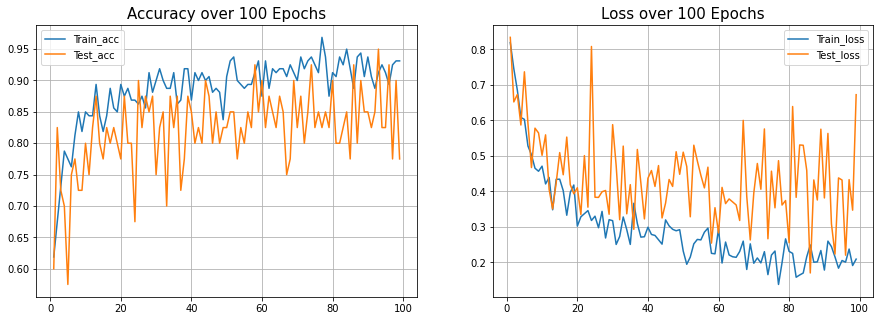

In [0]:
import matplotlib.pyplot as plt


def plot_acc_loss(result, epochs):
    acc = result.history['acc']
    loss = result.history['loss']
    val_acc = result.history['val_acc']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Test_acc')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test_loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_acc_loss(result, 100)

In [0]:
model.save('/content/drive/My Drive/UiPath-COVID-19/Best_weights/Covid_Multi.h5')

Predict

In [0]:

#Dont forget shuffle false
#See https://github.com/keras-team/keras/issues/6499
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_dir="/content/drive/My Drive/UiPath-COVID-19/Data/all/test"
eval_generator = test_datagen.flow_from_directory(
        test_dir,target_size=IMAGE_SIZE,
        batch_size=1,
        shuffle=True,
        seed=42,
        
        class_mode="categorical")
eval_generator.reset()    


Found 27 images belonging to 3 classes.


In [0]:
eval_generator.reset()  
x = model.evaluate_generator(eval_generator,
                           steps = np.ceil(len(eval_generator) / BATCH_SIZE),
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1
                           )


print('Test loss:' , x[0])
print('Test accuracy:',x[1])

#Poor test accuracy due to the small dataset size

3/3 [==============================] - 0s 68ms/step
Test loss: 0.12187475773195426
Test accuracy: 1.0


In [0]:
eval_generator.filepaths[1]

'/content/drive/My Drive/UiPath-COVID-19/Data/all/test/covid/nejmoa2001191_f4.jpeg'

In [0]:
pred=model.predict_generator(eval_generator,verbose=1)
loss, acc = model.evaluate_generator(eval_generator, verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)
print(predicted_class_indices)
labels = {0: 'covid', 1: 'normal', 2: 'pneumonia_bac'}
predictions = [labels[k] for k in predicted_class_indices]
acc=np.max(pred, axis=1)*100
loss=np.min(pred, axis=1)*100
filenames=eval_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions,
                      "Accuracy": acc,
                      "Loss": loss})
results["Filename"] = results["Filename"].apply(lambda x: str(x).split("/")[1])
results["Predictions"] = results["Predictions"].apply(lambda x: str(x).upper())
results["Accuracy"] = results["Accuracy"].apply(lambda x: str(round(x, 2))+"%")
results["Loss"] = results["Loss"].apply(lambda x: str(round(x, 2))+"%")
results

27/27 [==============================] - 1s 25ms/step - loss: 0.3542 - acc: 0.8889
[1 1 2 2 0 1 0 2 1 1 1 0 2 0 1 2 1 0 0 1 0 2 0 1 1 1 0]


,Filename,Predictions,Accuracy,Loss
0,nejmoa2001191_f3-PA.jpeg,NORMAL,97.54%,0.06%
1,nejmoa2001191_f4.jpeg,NORMAL,97.35%,0.54%
2,nejmoa2001191_f5-PA.jpeg,PNEUMONIA_BAC,87.18%,5.51%
3,radiol.2020200490.fig3.jpeg,PNEUMONIA_BAC,49.1%,7.62%
4,ryct.2020200028.fig1a.jpeg,COVID,99.98%,0.0%
5,ryct.2020200034.fig2.jpeg,NORMAL,85.6%,0.23%
6,ryct.2020200034.fig5-day0.jpeg,COVID,83.67%,3.93%
7,ryct.2020200034.fig5-day4.jpeg,PNEUMONIA_BAC,93.11%,1.71%
8,ryct.2020200034.fig5-day7.jpeg,NORMAL,98.57%,0.05%
9,NORMAL2-IM-1385-0001.jpeg,NORMAL,97.34%,0.2%


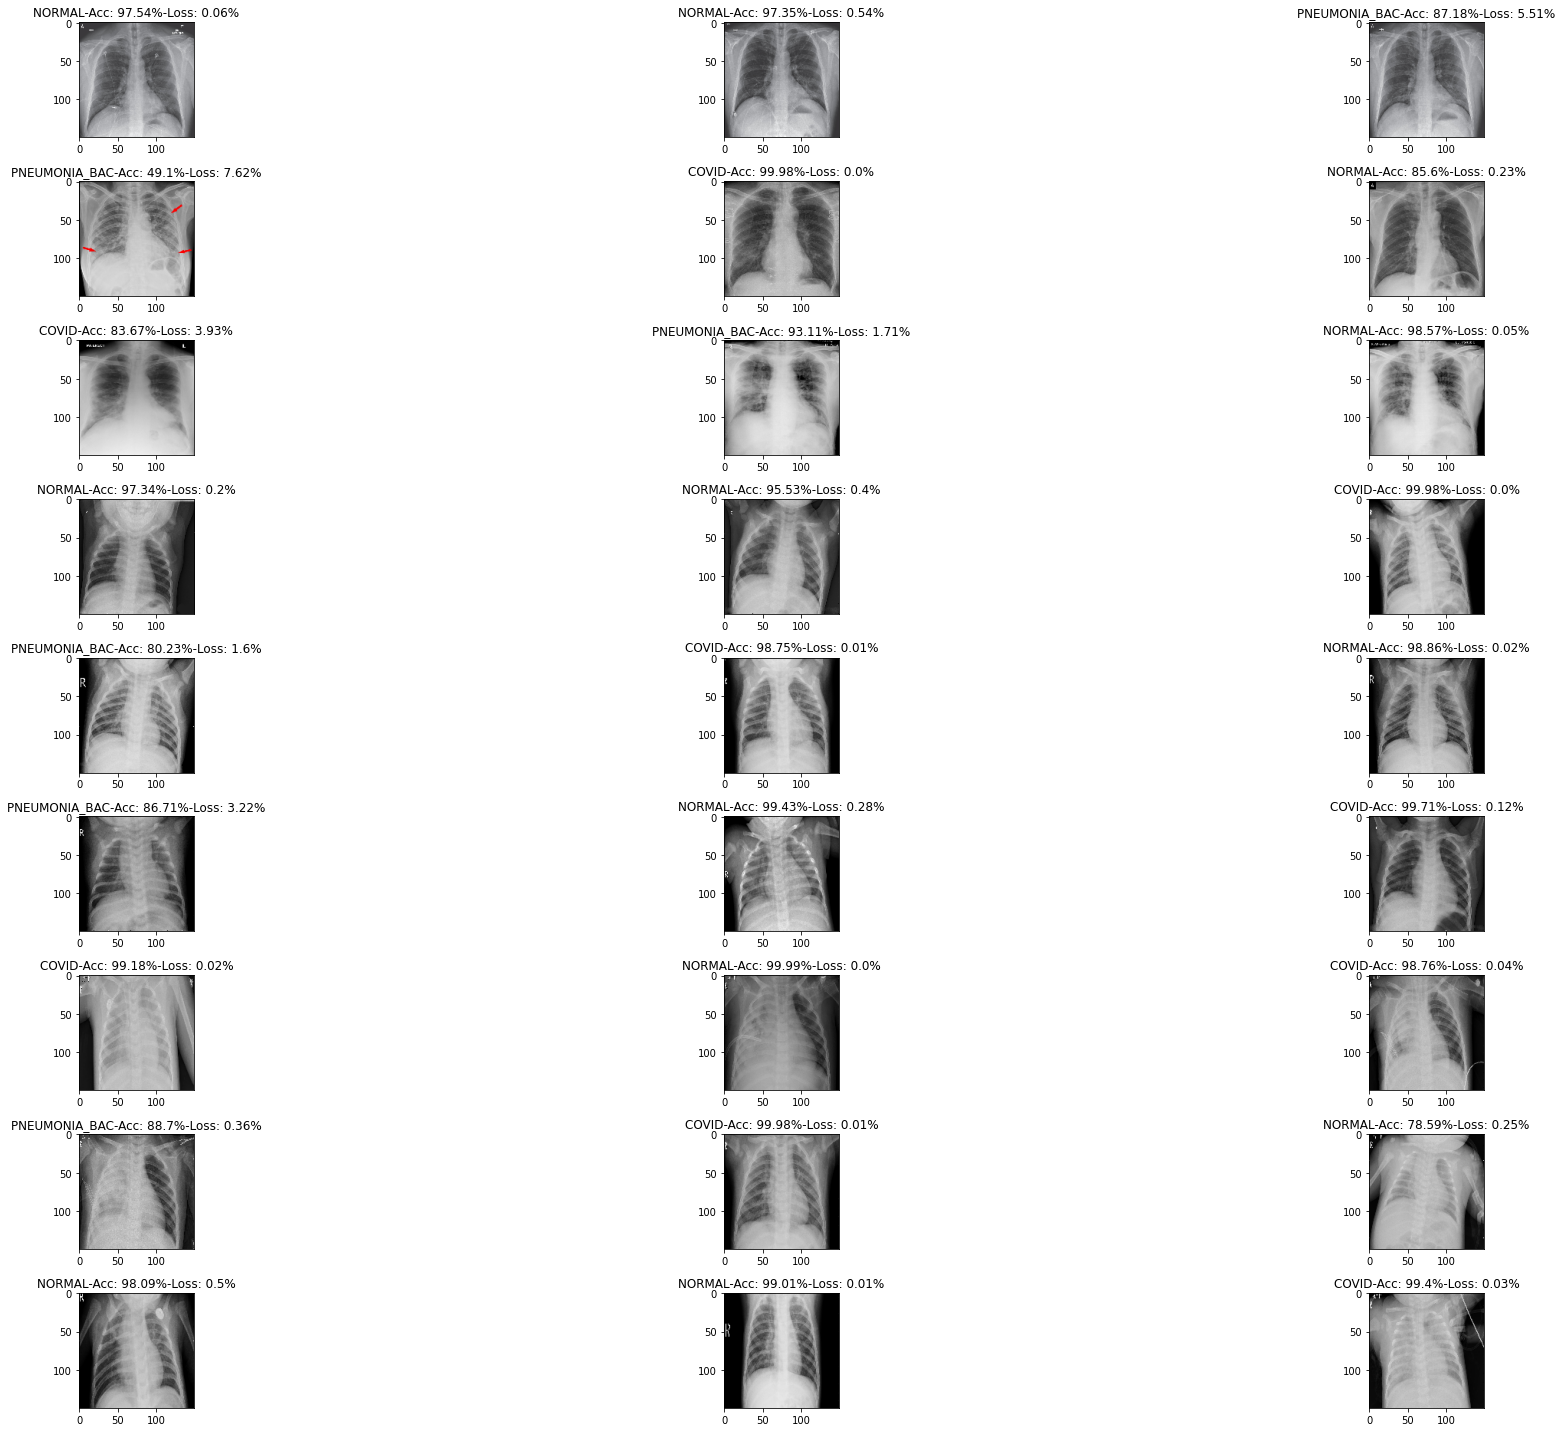

In [0]:
files = results["Filename"]
predictions = results["Predictions"]
acc = results["Accuracy"] 
loss = results["Loss"]
f, ax = plt.subplots(9,3, figsize=(40, 20))
for i in range(len(files)):
  img_path = eval_generator.filepaths[i]
  img = load_img(img_path, target_size=(150, 150))
  file_name = files[i]
  ax.ravel()[i].imshow(img, cmap='gray')
  ax.ravel()[i].set_title(predictions[i]+"-Acc: "+acc[i]+"-Loss: "+loss[i])
  plt.tight_layout()

## Atention map:


In [0]:
def display_heatmap(new_model, img_path, ids, preprocessing=None):
    # The quality is reduced.
    # If you have more than 8GB of RAM, you can try to increase it.
    img = load_img(img_path, target_size=(150, 150))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    if preprocessing is not None:
        x = preprocess_input(x)

    out = new_model.predict(x)

    heatmap = out[0]  # Removing batch axis.

    if K.image_data_format() == 'channels_first':
        heatmap = heatmap[ids]
        if heatmap.ndim == 3:
            heatmap = np.sum(heatmap, axis=0)
    else:
        heatmap = heatmap[:, :, ids]
        if heatmap.ndim == 3:
            heatmap = np.sum(heatmap, axis=2)

    plt.imshow(heatmap, interpolation="none")
    plt.show()

In [0]:
img_path = eval_generator.filepaths[1]
#load_img(img_path, target_size=(150, 150))
display_heatmap(model, img_path, 0, preprocessing=None)

IndexError: ignored

## Predict on 1 image:

In [0]:
model = load_model('/content/drive/My Drive/UiPath-COVID-19/Best_weights/Covid_Multi.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
img_path = "/content/drive/My Drive/UiPath-COVID-19/Data/all/test/covid/nejmoa2001191_f3-PA.jpeg"

def plot_output_pred(img_path):
  name = img_path.split("/")
  name = name[len(name)-1]
  img = load_img(img_path, target_size=(150, 150))
  img = img_to_array(img)/255
  x = preprocess_input(np.expand_dims(img.copy(), axis=0))
  pred_class = model.predict_classes(x)
  pred = model.predict(x)
  print(pred_class[0])

In [0]:
img_path = "/content/drive/My Drive/UiPath-COVID-19/Data/all/test/covid/nejmoa2001191_f3-PA.jpeg"

plot_output_pred(img_path)

0


Optional: Finetuning with a learning rate of 5E-5

In [0]:
model.compile(loss='categorical_crossentropy',
              
              optimizer=optimizers.Adam(lr=5e-5),
              metrics=['acc'])

result=model.fit_generator(train_batches,
                        steps_per_epoch =STEP_SIZE_TRAIN,
                        validation_data = valid_batches,
                        validation_steps = STEP_SIZE_VALID,
                        epochs= 20,                        
                       )

Epoch 1/20


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


16/16 [==============================] - 4s 274ms/step - loss: 0.2058 - acc: 0.9187 - val_loss: 0.5493 - val_acc: 0.8000
Epoch 2/20
16/16 [==============================] - 4s 246ms/step - loss: 0.1662 - acc: 0.9250 - val_loss: 0.3069 - val_acc: 0.8750
Epoch 3/20
16/16 [==============================] - 4s 256ms/step - loss: 0.2015 - acc: 0.9125 - val_loss: 0.2550 - val_acc: 0.9000
Epoch 4/20
16/16 [==============================] - 4s 256ms/step - loss: 0.1732 - acc: 0.9312 - val_loss: 0.2438 - val_acc: 0.8750
Epoch 5/20
16/16 [==============================] - 4s 259ms/step - loss: 0.1318 - acc: 0.9750 - val_loss: 0.3707 - val_acc: 0.8250
Epoch 6/20
16/16 [==============================] - 4s 255ms/step - loss: 0.1764 - acc: 0.9500 - val_loss: 0.3890 - val_acc: 0.8500
Epoch 7/20
16/16 [==============================] - 4s 259ms/step - loss: 0.2147 - acc: 0.9062 - val_loss: 0.2264 - val_acc: 0.9250
Epoch 8/20
16/16 [==============================] - 4s 260ms/step - loss: 0.1772 - acc:

In [0]:
eval_generator.reset()  
x = model.evaluate_generator(eval_generator,
                           steps = np.ceil(len(eval_generator) / BATCH_SIZE),
                           use_multiprocessing = False,
                           verbose = 1,
                           workers=1
                           )


print('Test loss:' , x[0])
print('Test accuracy:',x[1])


3/3 [==============================] - 0s 36ms/step
Test loss: 0.091110123321414
Test accuracy: 1.0


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
